In [1]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler,AutoencoderKL
import torch
from pytorch_lightning import seed_everything
from PIL import Image
from controlnet_aux import ZoeDetector
from ip_adapter import IPAdapter


/home/liuxiaoyu/anaconda3/envs/smartcontrol/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/liuxiaoyu/anaconda3/envs/smartcontrol/lib/python3.8/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [2]:
base_model_path = "/data/Protogen_x3.4_Official_Release"
vae_model_path = "stabilityai/sd-vae-ft-mse"
controlnet_path = "lllyasviel/control_v11f1p_sd15_depth"
depth_path = 'lllyasviel/Annotators'
smart_ckpt = "./220.ckpt"
# negative_prompt_path = '/home/liuxiaoyu/compare/controlnet/realisticvision-negative-embedding'

image_encoder_path = "models/image_encoder/"
ip_ckpt = "models/ip-adapter_sd15.bin"

device = "cuda"

load pretrain model

In [3]:
controlnet = ControlNetModel.from_pretrained(controlnet_path, torch_dtype=torch.float16)


vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model_path, controlnet=controlnet,vae=vae, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


extract depth

/home/liuxiaoyu/anaconda3/envs/smartcontrol/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552411/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


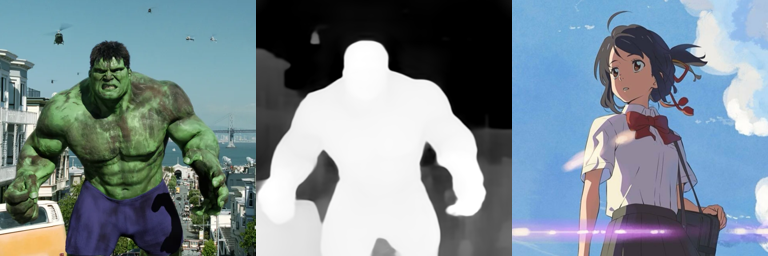

In [4]:

preprocessor = ZoeDetector.from_pretrained(depth_path)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


image = Image.open("assets/images/hulk.png")
depth_map = preprocessor(image)
ip_image = Image.open("assets/images/girl.png")
depth_map = depth_map.resize((512,512))
ip_image = ip_image.resize((512,512))

image_grid([image.resize((256, 256)), depth_map.resize((256, 256)), ip_image.resize((256, 256))], 1, 3)



Forward

It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, tokenizer, unet, controlnet, scheduler, safety_checker, feature_extractor, image_encoder to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.
Global seed set to 12345


(512, 512, 3)


100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


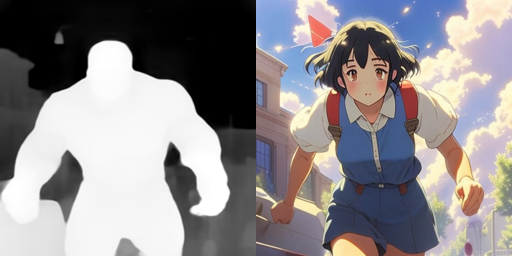

In [5]:

prompt = 'a girl in the street in anime style'

from smartcontrol import register_unet
pipe = register_unet(pipe,smart_ckpt)
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

seed_everything(12345)
import numpy as np
print(np.array(ip_image).shape)
output = ip_model.generate(pil_image=ip_image, image=depth_map, num_samples=1, num_inference_steps=50)[0]
image_grid([ depth_map.resize((256, 256)), output.resize((256, 256))], 1, 2)
